### Imports

In [1]:
import torch
import torch_geometric
import torch.nn as nn
import networks
import datasetLoader
import evaluation
import utils
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import networkx as nx
from typing import Literal
import wandb
import copy

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(evaluation)
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\utils.py'>

### Parameters

In [2]:
batch_size = 64                 # 64 used for Graphs in PGE (PGExplainer/codes/forgraph/config.py)      1 takes forever in current model

learning_rate_gnn = 0.001        #0.001 on ADAM
epochs_gnn = 1000
early_stopping = 500
dropout = 0.0

loss = nn.CrossEntropyLoss()           # cross entropy loss?!

datasetName: Literal['BA-2Motif','MUTAG'] = 'MUTAG'
MUTAG= True if datasetName == 'MUTAG' else False
# lr scheduler? => not used in orig
# softmax after linear layer?       -> Not really needed since kinda used in CEL; PyTorch best practice to just use Linear in final layer

# DONE: Xavier uniform distr used for init in PGExplainer
# DONE: dropout     NOT USED IN OG
# DONE: early stopping with validation set

#### Load and visualize dataset

In [3]:
data, label = datasetLoader.loadGraphDataset(datasetName)               # TODO: adjs matrix is not compatible with GraphConv. Needs to be converted to edge_index (see RE_PGE datasets/utils)

manual_seed = 42
generator1 = torch.Generator().manual_seed(manual_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)
    
# TODO: Color different classes? Problem: BA2Motif Graph datasets have no node labels?!
ind = 7
print(train_dataset[ind].y)
graph = Data(train_dataset[ind].x, train_dataset[ind].edge_index)
utils.plotGraphAll(graph, MUTAG=MUTAG, graph_task=True, save_path=f"{datasetName}-VIS.pdf")

train_loader = DataLoader(train_dataset, batch_size, True)
val_loader = DataLoader(val_dataset, batch_size, True)
test_loader = DataLoader(test_dataset, batch_size)

tensor(1)


In [4]:
selected_data = []
selectedIndices = []
for i in range(0, len(data)):
    if data[i].y == 0 and torch.sum(data[i].gt_mask) > 0:
        selectedIndices.append(i)
        selected_data.append(data[i])
        
print(len(selected_data))

1015


In [7]:
print(train_dataset[0].edge_index)
print(train_dataset[0].gt_mask)

tensor([[ 0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,
          4,  5,  5,  6,  7,  8,  8,  8,  9,  9, 10, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1, 14, 20,  0,  2,  7, 10, 17, 19,  1,  3,  4,  5,  6,  9,  2, 12, 15,
          2,  2,  8,  2,  1,  5, 13, 16,  2, 11,  1, 18,  9,  3,  8,  0,  3,  8,
          1, 10,  1,  0, 21, 23, 24, 20, 22, 24, 21, 23, 20, 22, 20, 21]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])


## Training Loop GraphGNN

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gnn = networks.GraphGNN(features = train_dataset[0].x.shape[1], labels=2, dropout=dropout).to(device)       # temp.y.shape[0] is wrong!!! TODO: how do I get #labels from loader?? take from loader.dataset? Store with dataset
gnn_optimizer = torch.optim.Adam(params = gnn.parameters(), lr = learning_rate_gnn)         # TODO: understand params

print(f"Training on {len(train_loader.dataset)} graphs with batch size {batch_size}")

early_stop_counter = 0
min_val_loss = 1000.0
best_val_acc = 0
best_epoch = 0

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

params = {
    "learning_rate": learning_rate_gnn,
    "epochs": epochs_gnn,
    "batch_size": batch_size,
    "dataset_name": datasetName,
    "early_stopping": early_stopping
}

wandb.init(project="GNN training", config=params)

for epoch in range(0, epochs_gnn) :
    print(f'\n------------------ EPOCH {epoch + 1} -------------------')

    gnn.train()

    train_acc_sum = 0
    num_batches = 0.0
    train_loss = 0.0

    for batch_index, data in enumerate(train_loader):
        batch_size_ratio = len(data)/batch_size
        num_batches += batch_size_ratio
        
        gnn_optimizer.zero_grad()       # Reset parameters

        data = data.to(device)
        
        # get model embeddings (node representations)?
        out = gnn.forward(data.x, data.edge_index, data.batch)

        # calc cross entropy(???)loss between real label and predicted label
        # needs to be calculated across batch
        currLoss = loss(out, data.y)

        # loss backward
        currLoss.backward()
        
        torch.nn.utils.clip_grad_norm_(gnn.parameters(), max_norm=2)    # clip gradient above 2(for ba2motfis according to reimplementation) to stop "overlearning"?

        # optimizer step
        gnn_optimizer.step()

        # predicted labels
        preds = out.argmax(dim=1)
        train_acc_sum += torch.sum(preds == data.y)                         # DONE: works with batches?
        
        train_loss += batch_size_ratio * currLoss.item()                    # use currLoss.item() instead of currLoss for numeric value

    final_train_acc = train_acc_sum/(num_batches*batch_size)                # num_batches*batch_size = len(train_loader.dataset) = #graphs

    gnn.eval()

    # avg loss
    print(f"average training loss: {train_loss/num_batches}, training acc: {final_train_acc}")

    train_losses.append(train_loss/num_batches)
    train_accuracies.append(final_train_acc)

    val_acc, valLoss = evaluation.evaluateGraphGNN(gnn, val_loader)
    
    print(f"validation loss: {valLoss}, validation acc: {val_acc}")
    
    wandb.log({"val/loss": valLoss, "val/acc": val_acc, "train/loss": train_loss/num_batches, "train/acc": final_train_acc})

    val_losses.append(valLoss)
    val_accuracies.append(val_acc)

    if(val_acc > best_val_acc):
        best_val_acc = val_acc
        best_epoch = epoch
        # TODO: STORE MODEL CHECKPOINT HERE!
        best_model_state = copy.deepcopy(gnn.state_dict())
    if(valLoss < min_val_loss):
        min_val_loss = valLoss
        early_stop_counter = 0
        if val_acc == best_val_acc: best_model_state = copy.deepcopy(gnn.state_dict())
    elif(valLoss > min_val_loss):
        early_stop_counter += 1
        if early_stop_counter >= early_stopping:
            print("Stopping training due to early stopping threshold")
            break

print(f"highest validation accuracy: {best_val_acc} in epoch {best_epoch + 1}") 
print("-------------Loading best model state-------------")

gnn.load_state_dict(best_model_state)
gnn.eval()

test_acc, testLoss = evaluation.evaluateGraphGNN(gnn, test_loader)
print(f"test loss: {testLoss}, test acc: {test_acc}")
wandb.log({"test/loss": testLoss, "test/acc": test_acc})

torch.save(gnn.state_dict(), f"models/{datasetName}")

wandb.finish()

Training on 800 graphs with batch size 64


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tristan-schulz2001 (tristan-schulz2001-tu-dortmund) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



------------------ EPOCH 1 -------------------
average training loss: 0.7935702562332153, training acc: 0.5987499952316284
validation loss: 1.1988109731674195, validation acc: 0.4000000059604645

------------------ EPOCH 2 -------------------
average training loss: 0.5408803486824035, training acc: 0.7925000190734863
validation loss: 0.9238001155853272, validation acc: 0.5

------------------ EPOCH 3 -------------------
average training loss: 0.4161616659164429, training acc: 0.9049999713897705
validation loss: 0.5415501546859741, validation acc: 0.8700000047683716

------------------ EPOCH 4 -------------------
average training loss: 0.3116606283187866, training acc: 0.9612500071525574
validation loss: 0.30579375505447387, validation acc: 0.9800000190734863

------------------ EPOCH 5 -------------------
average training loss: 0.2392314374446869, training acc: 0.9750000238418579
validation loss: 0.5561155891418457, validation acc: 0.550000011920929

------------------ EPOCH 6 -------

test/acc,▁
test/loss,▁
train/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,████████████████████████████████████▁▁██
val/loss,▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,0.98
test/loss,0.10801
train/acc,1
train/loss,3e-05
val/acc,1


### GCNConv instead of GraphConv
average training loss: 0.3523677970215635, training acc: 0.8458213210105896
validation loss: 0.47687009828431265, validation acc: 0.7921478152275085, test loss: 0.5093637616952993, test acc: 0.7695852518081665
highest validation accuracy: 0.8152424693107605 in epoch 452

### Save Model
Does not safe training/validation losses

In [5]:
torch.save(gnn.state_dict(), f"models/BA-2Motif")

### Load model

In [4]:
gnn = networks.GraphGNN(features = train_dataset[0].x.shape[1], labels=2)
gnn.load_state_dict(torch.load("models/BA-2Motif", weights_only=True))

<All keys matched successfully>

## Code used to verify that DT actually relies on motifs

In [ ]:
import torch_geometric.utils


masked_test_data = []
for data in test_dataset:
    data = data.clone()
    keep_edges = ~data.gt_mask
    #keep_edges = torch.ones_like(data.gt_mask)
    #keep_edges[-1] = 0
    #keep_edges = keep_edges.bool()
    
    # Replace with masked version
    data.edge_index = data.edge_index[:, keep_edges]
    
    masked_test_data.append(data)

test_loader = DataLoader(masked_test_data, batch_size)

In [10]:
print(masked_test_data[0].edge_index)

tensor([[ 0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
          2,  3,  4,  5,  5,  6,  6,  7,  8,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 20, 20, 21, 21, 22, 22, 23, 23, 24],
        [ 1, 20,  0,  2,  3,  5,  6,  8,  9, 10, 12, 13, 14, 15, 19,  1,  4, 17,
         18,  1,  2,  1,  7,  1, 16,  5,  1, 11,  1,  1,  8,  1,  1,  1,  1,  6,
          2,  2,  1,  0, 21, 24, 20, 22, 21, 23, 22, 24, 20]])


### Calculate test accuracy and loss

In [12]:
gnn.eval()

test_acc, testLoss = evaluation.evaluateGraphGNN(gnn, test_loader)
print(f"test loss: {testLoss}, test acc: {test_acc}")

test loss: 0.9996273756027222, test acc: 0.6299999952316284


### Plot Losses

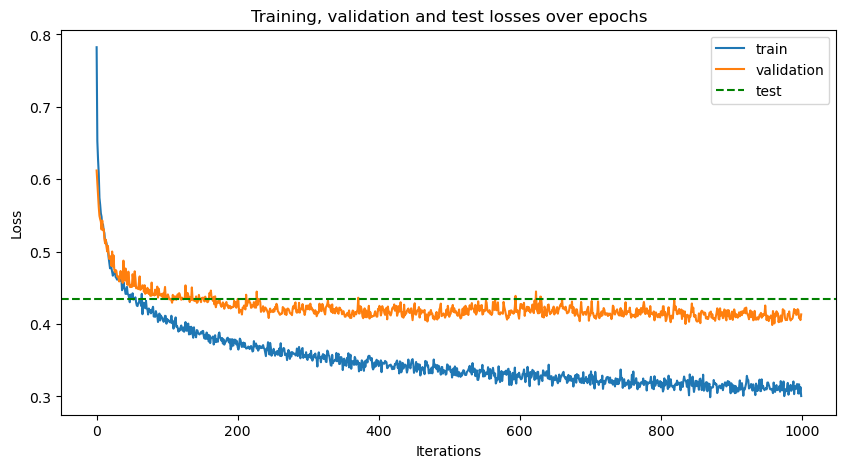

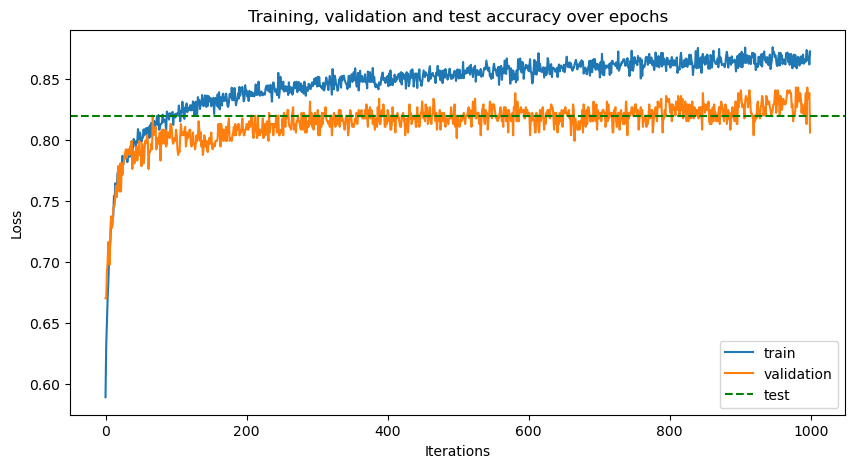

In [27]:
#   Losses
plt.figure(figsize=(10, 5))
plt.title("Training, validation and test losses over epochs")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.axhline(y=testLoss, linestyle='dashed', color = "green", label = "test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#   Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training, validation and test accuracy over epochs")
plt.plot(train_accuracies, label="train")
plt.plot(val_accuracies, label="validation")
plt.axhline(y=test_acc, linestyle='dashed', color = "green", label = "test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Testing

In [60]:
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.datasets.motif_generator import HouseMotif
from torch_geometric.datasets.motif_generator import CycleMotif
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader

dataset1 = ExplainerDataset(
            graph_generator=BAGraph(20, 1),
            motif_generator=HouseMotif(),
            num_motifs=1,
            num_graphs=400,
            transform=T.Constant()      # appends value 1 node feature for every node
        )

dataset2 = ExplainerDataset(
            graph_generator=BAGraph(20, 1),
            motif_generator=CycleMotif(5),
            num_motifs=1,
            num_graphs=400,
            transform=T.Constant()
        )

dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])

print(dataset[0])

print(dataset)
dataset[0].y = torch.tensor([0])

print(dataset[0].y)

train_loader = DataLoader(dataset1, batch_size = 1, shuffle = True)

print(next(iter(train_loader)).y)

Explanation(edge_index=[2, 48], y=[25], edge_mask=[48], node_mask=[25], x=[25, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,
        3])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,
        3])


In [74]:
dataset1 = ExplainerDataset(
            graph_generator=BAGraph(20, 1),
            motif_generator=HouseMotif(),
            num_motifs=1,
            num_graphs=1
        )



Explanation(edge_index=[2, 50], y=[25], edge_mask=[50], node_mask=[25])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  3,  3,  3,  3,  3,  3,  3,
          4,  5,  6,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 16, 17, 18, 19,
         20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 24, 24, 17, 20],
        [ 1,  3,  5,  6, 13, 14, 16, 17,  0,  2,  1,  0,  4,  7,  9, 10, 12, 19,
          3,  0,  0, 11,  3, 15,  3,  3,  6,  3,  0,  0,  8,  0, 18,  0, 16,  3,
         21, 23, 24, 24, 22, 20, 21, 23, 22, 20, 20, 21, 20, 17]])


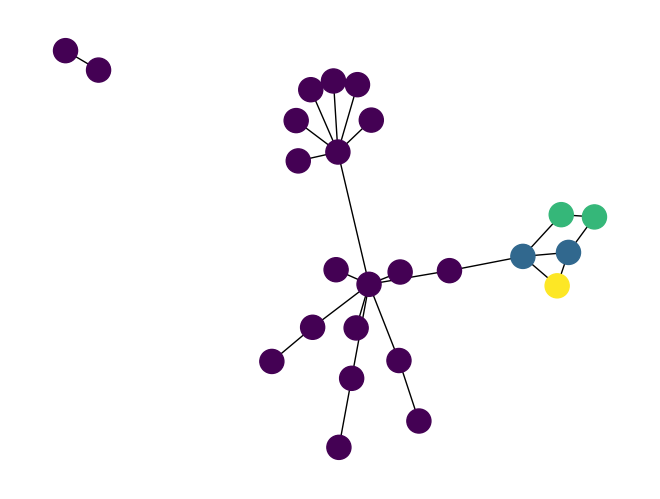

In [75]:
print(dataset1[0])
print(dataset1[0].edge_index)
g = torch_geometric.utils.to_networkx(dataset1[0], to_undirected=True)

colors = []

for i, j in enumerate(dataset1[0].y):
    colors.append([j.item()])

nx.draw(g, node_color = colors)

In [117]:
import pickle

# Replace 'path_to_your_file.pkl' with the actual path to your PKL file
file_path = 'syn1.pkl'

# Open the file in binary mode and load the data
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Now 'data' contains the deserialized Python object
print(data[4])

# Shape of data syn1 (BA-Shapes) from PGExplainer pkl:
# data[0] : (700, 700)  => adjacency matrix (One graph with 700 nodes)
# data[1] : (700, 10) => node features??
# data[2] : (700, 4) =>
# data[3] : (700, 4) =>
# data[4] : (700, 4) =>
# data[5] : (700) => True/False, Node Mask?

adj = torch.tensor(data[0])

edge_index = adj.nonzero().t().contiguous()

label_indices = torch.argmax(torch.tensor(data[2]), dim=1)

data_graph = Data(edge_index= edge_index, y= label_indices, num_nodes = 700)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]


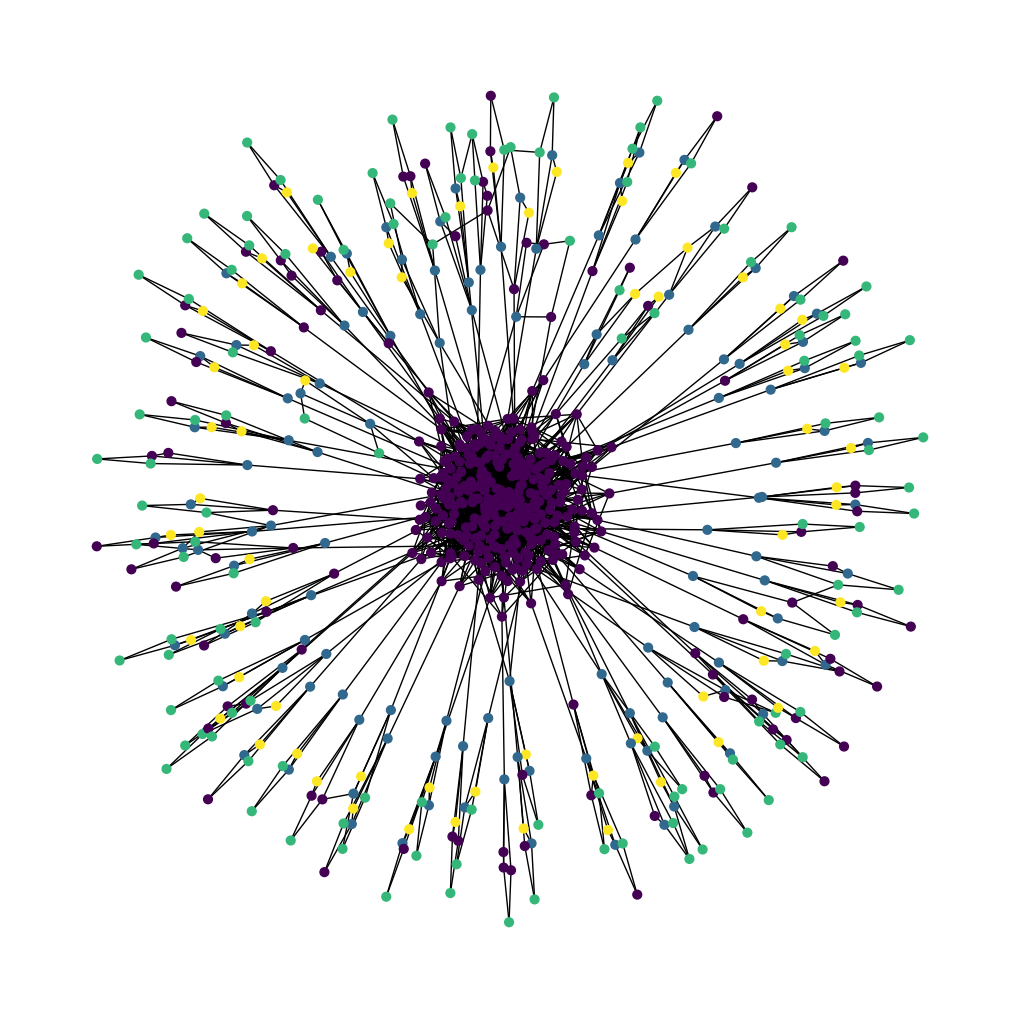

In [124]:
g = torch_geometric.utils.to_networkx(data_graph, to_undirected=True)

colors = []

for i, j in enumerate(data_graph.y):
    colors.append([j.item()])

pos = nx.spring_layout(g, seed=42)          # try kamada_kawai_layout
plt.figure(figsize=(10, 10))  # You can adjust the size as needed

nx.draw(g, pos, node_size=40,font_size=8, node_color = colors)
#nx.draw(g, node_color = colors)

In [ ]:
import pickle

# Replace 'path_to_your_file.pkl' with the actual path to your PKL file
file_path = 'datasets/raw/BA-2motif.pkl'

# Open the file in binary mode and load the data
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Now 'data' contains the deserialized Python object
print(data[1][0])

# Shape of data BA-2motif from PGExplainer pkl:
# data[0] : (1000, 25, 25)  => adjacency matrix (1000 graphs with 25 nodes)
# data[1] : (1000, 25, 10) => node features (10x0.1)
# data[2] : (1000, 2) => label

adj = torch.tensor(data[0])

edge_index = adj.nonzero().t().contiguous()

#label_indices = torch.argmax(torch.tensor(data[2]), dim=1)

#data_graph = Data(edge_index= edge_index, y= label_indices, num_nodes = 700)

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0

NameError: name 'Data' is not defined

In [40]:
generator1 = torch.Generator().manual_seed(42)
generator2 = torch.Generator().manual_seed(42)
set1, set2 = torch.utils.data.random_split(range(10), [3, 7])
set3, set4, set5 = torch.utils.data.random_split(range(30), [0.3, 0.3, 0.4])

print("Set 1:")
print(set1[0])
print(set1[1])
print(set1[2])
print("Set 2:")
print(set2[0])
print(set2[1])
print(set2[2])
print(set2[3])
print(set2[4])
print(set2[5])
print(set2[6])

Set 1:
9
3
5
Set 2:
2
6
4
8
7
0
1
